# Contents
- Dataset Loading (Sine Waves)
    - Model Building
        - Simple Linear
        - LSTM
    - Model Output / Analysis
- Dataset Loading (Stocks)
    - Model Output / Analysis

## About
We will walk through the simplest possible DNN model training implimentations for forecast modeling. As a note, we will be building on [the simple image notebook](https://github.com/josiahls/PyTorchTensorflowImageML/blob/master/pytorch_tensorflow_image_ml/notebooks/pytorch_analysis.ipynb). So if we skip through something, we most likely talked about it in detail here. If not, definitely create and issue, or a PR to either repo.

# Dataset Loading (Sine Waves)
In the image dataset we use the MNIST dataset for model training and testing. There are going to be some big differences between these two, which is good because hopefully we will gain a better general understanding of deep learning models in general. To say... we want to _generalize_ are understanding of deep learning models. 

Now, we have two options for a dataset. We can generate a forecast dataset pretty easily, such as train a model to predict a sine function output. However I think it would be more interesting to forecast something "real world". So screw it! Lets get make a model that will make us rich!

[Stocks](https://www.kaggle.com/dgawlik/nyse) will be the main dataset that we will test on. However, like the MNIST, we really need a dataset that can serve as our "sanity" dataset. Deep learning models are hard as it is, so being able to predict some known, and simple will be important. So our second dataset will be a sine wave:
![Sine Wave](../../res/sine_wave.png)

If our model can't predict the structure of a sine wave, how can we hope for it to predict something like stocks? So we will setup both datasets so thay make sense. Lets start with our sine dataset.


In [43]:
import numpy as np
N = 1000
time_steps = np.arange(N)
print(f'The first five time steps: {time_steps[:5]} \nThe first five sine values {np.sin(time_steps)[:5]}')

The first five time steps: [0 1 2 3 4] 
The first five sine values [ 0.          0.84147098  0.90929743  0.14112001 -0.7568025 ]


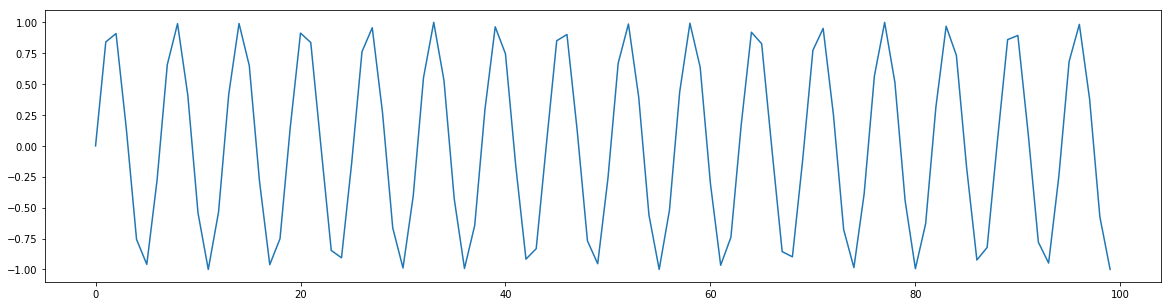

In [44]:
# Lets actually plot the sine wave (30 time steps this time)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20,5)

plt.plot(np.sin(time_steps)[:100])
plt.show()

Ok, pretty straight forward. Like at the end of [our image notebook](https://github.com/josiahls/PyTorchTensorflowImageML/blob/master/pytorch_tensorflow_image_ml/notebooks/pytorch_analysis.ipynb).

A good question you should ask is "where the hell is our `y`?" So our `x` is all of the sequences before, and our `y` is the _next_ value in the sequence. This is like me asking you, "Given a sequence of `[4, 5, 6, 7]`, what is the next value `[?]`?". Our `x` is the `[4, 5, 6, 7]`, our `y` is `[8]`. We want our model to see `[4, 5, 6, 7]` and realize that the next value is going to be `[8]`!

Ok, so do we just move to our model? "But wait!" you might ask. "The image model used classifications! This seems to just involve values. Are we going to still one hot it?" This is a good question! Since the values could be .5, .57, .58, .58123233... I would say that this is a continuous problem since there would be infinitely many classes if we tried making them so. _As a side note, if you **really** wanted this to be a classification problem, you could descritize them_. _A user here [Bucketization](https://github.com/pytorch/pytorch/issues/7284) talks about adding this. Plus, I do this to steering angles in [Steering Angle NN](https://github.com/josiahls/FCNeuralNet)._

But we are going to use a continuous implimentation. So we have a sine wave, lets break it up into samples with x and y values. Now, we need to think about the shapes for our x and y... Our x should have some description of past values / or a sequence of values. How big of a sequence do we want? Remember, If I gave you a sequence of `[4, 5, 6, 7]` you were able to predict decently that the `y` should be `[8]`. _What if I only gave you `[5]` as the x?_ You wouldn't get very far would you? So the size of our sequence matters, and I would say that the bigger the sequence the better the model will be, however realize that also the bigger the sample / more dimensions we add, the slower / bigger the model is going to be. This is a similar problem to feeding a model a 2000x2000 pixel image. So there is a balance that unfortunately... we have to _experiment with_.

So lets think about this, lets choose a size of 9 maybe for our `x`. These means the model gets 9 previous values to use to predict the next value. If the model does poorly, we just increase the sequence size. So:

N = The number of samples are are using for our training / test set. Remember from the image notebook, we separated the `x` into a train and test set. Each has a different size N. 

F = The size of the `x` sample. For now, we try 9, and `y` will be the 10th value in the sequence

K = 1. The size of `y`. This is going to be 1. Remember from the image example that we had 10 classes and did one hot. Thus in that case, our K was 10. _**But we are using continuous data not categorical**_. Which makes it easier because we only have 1 dimension to use. The draw back here, is that continuous data is harder generally to train on, and requires more data. Luckly for us, all we need to do is generate more sine values!

We expect x.shape &rarr; (N, F)
and y.shape &rarr; (N, K)

In [45]:
sequence_size_f = 9  # F, notice, if you change the to 10, the reshape fails because...
x_and_y = np.sin(time_steps)
# Understanding the reshape method is probably one of the most important things you can do in data science.
# Extremely common, it is a good idea to experiment with this. Took me a few months...
reshaped_x_and_y = x_and_y.reshape(-1, sequence_size_f + 1)  # The +1 is the column with y!  
print(f' {reshaped_x_and_y.shape} Cool, we now have 50 sequences, 10 elements long! 9 are x, 10th is y.')
x = torch.tensor(reshaped_x_and_y[:, :sequence_size_f]).float()
y = torch.tensor(reshaped_x_and_y[:, sequence_size_f:]).float()
print(f' X\'s shape is {x.shape} and Y\'s is {y.shape}')

 (100, 10) Cool, we now have 50 sequences, 10 elements long! 9 are x, 10th is y.
 X's shape is torch.Size([100, 9]) and Y's is torch.Size([100, 1])


Ok this is a little boring. What do these actually look like? Well, lets plot them! This time using a function.

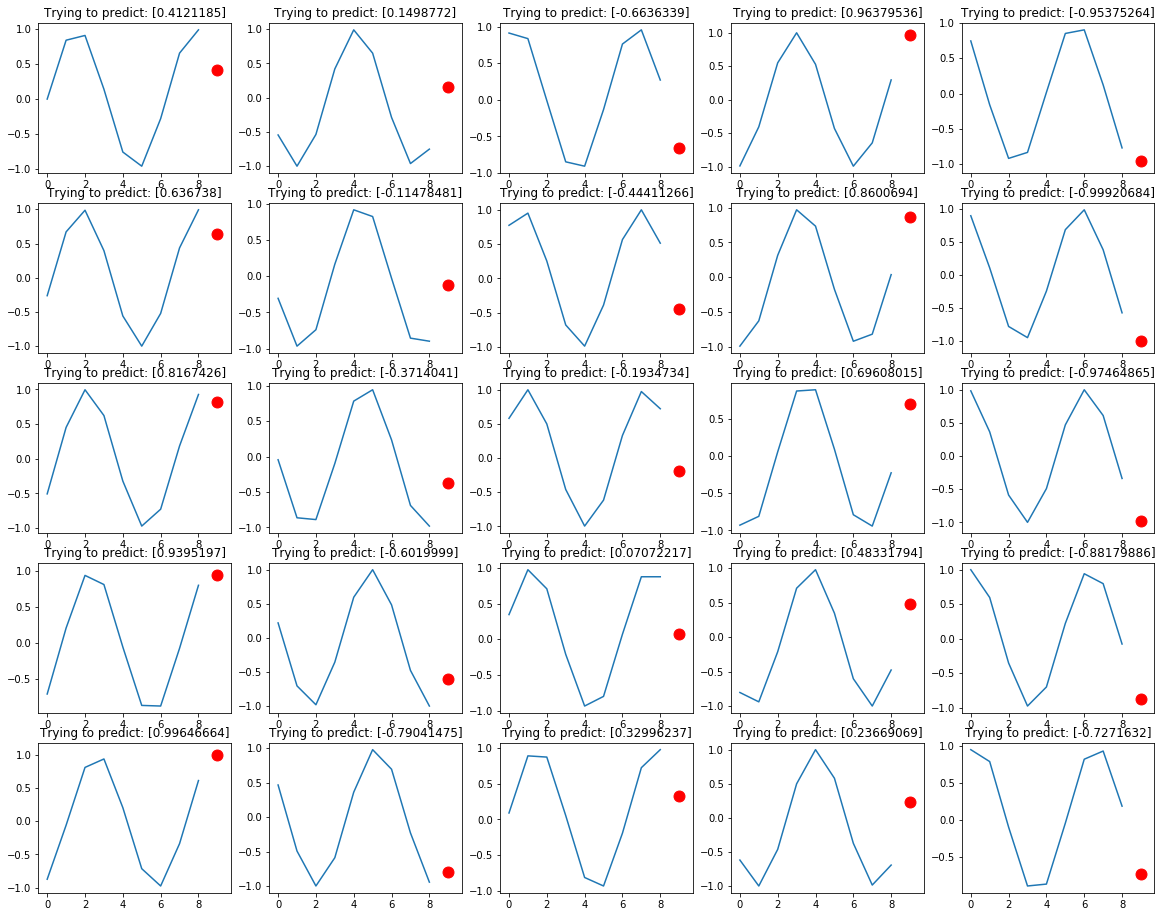

In [46]:
def plot_many_sequences(x, y, n_plots):
    mpl.rcParams['figure.figsize'] = (20,16)

    # Lets look at a bunch of them
    fig  = plt.Figure()
    with torch.no_grad():
        for i, some_sample_x in enumerate(x[:n_plots]):
            plt.subplot(np.sqrt(n_plots), np.sqrt(n_plots), i+1)
            plt.title(f'Trying to predict: {y[i]}')
            plt.plot(some_sample_x, zorder=1)
            plt.scatter(some_sample_x.shape[0],y[i],s=120,c='r', zorder=2)
    plt.show()
plot_many_sequences(x.numpy(), y.numpy(), 25)

Interesting! So the first 25 samples, this is what the model with be asked to predict. The blue line is the `x` (first 9), and the red dot is the `y` (10th).

# Model Building
Ok, **now** we can continue to our model. Lets build it like usual. In our image network we used 128 neurons. The reason we did this was just intuition. The image size (`x.shape[1]`) itself was 784... so we would most likely need more neurons not less. However _this time_ we only have 9 (`x.shape[1]` should be 9)... Since there are only 9 features, we really shouldn't need that many neurons. But of course... we could be wrong!

This time we are going to add an init model method so it is easier to reset the model.


In [50]:
import torch 
from torch import optim
# Ref: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_nn.html
model = None
def init_model():
    return torch.nn.Sequential(
        torch.nn.Linear(x.shape[1], 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, y.shape[1]),
    )

We are also going to make a more formal training method that was in the image notebook!

In [102]:
def train(x, y, model=None, ln=1e-3, epochs=10, batch_size=5, model_progress_fn=None):
    if model is None:
        model = init_model()
    loss_fn = torch.nn.MSELoss(reduction='sum')
    learning_rate = ln

    y_tensor = torch.tensor(y).float()
    x_tensor = torch.tensor(x).float()
    batch_indices = np.arange(y_tensor.shape[0])
    
    # WATS THIS??!?!?!??
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for t in range(epochs):
        print(f' Epoch {t}')
        losses = []
        for batch in range(0, y_tensor.shape[0], batch_size):
            batch_x = x_tensor[batch_indices[batch:batch+batch_size]]
            batch_y = y_tensor[batch_indices[batch:batch+batch_size]]

            y_pred = model(batch_x)

            loss = loss_fn(y_pred, batch_y)
            losses.append(loss.detach())

            # Zero the gradients before running the backward pass.
            model.zero_grad()

            loss.backward()
            
            """
            WHERE DID:
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad
            GO?!?!?!?
            """
            optimizer.step()
        print(f' Average Loss {np.average(losses)}')
        
        if model_progress_fn is not None: 
            model_progress_fn(model=model)  # Dont worry about this. This is for visualizing the model.
    return model

Ok, so this time we are using an optimizer. A common one is either `optim.SGD(model.parameters(), lr=learning_rate)` or `optim.Adam([var1, var2], lr=0.0001)` noted [PyTorch Optimizers](https://pytorch.org/docs/stable/optim.html). This means all we need to do is define this optimizers at eh start, then just call `optimizer.step()`. These hopefully help the model learn using more advanced strategies. Definitely try others, or even try your own! Now lets see if this model will train! 

In [103]:
trained_model = train(x, y, epochs=100)

/Users/jlaivins/anaconda3/envs/master36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/Users/jlaivins/anaconda3/envs/master36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Epoch 0
 Average Loss 1.871175765991211
 Epoch 1
 Average Loss 0.7482309341430664
 Epoch 2
 Average Loss 0.2937602996826172
 Epoch 3
 Average Loss 0.11456970125436783
 Epoch 4
 Average Loss 0.0456254705786705
 Epoch 5
 Average Loss 0.019386792555451393
 Epoch 6
 Average Loss 0.009362654760479927
 Epoch 7
 Average Loss 0.005467003211379051
 Epoch 8
 Average Loss 0.003908467013388872
 Epoch 9
 Average Loss 0.003258928656578064
 Epoch 10
 Average Loss 0.0029728668741881847
 Epoch 11
 Average Loss 0.0028369894716888666
 Epoch 12
 Average Loss 0.0027653523720800877
 Epoch 13
 Average Loss 0.0027221578639000654
 Epoch 14
 Average Loss 0.002691964153200388
 Epoch 15
 Average Loss 0.0026678976137191057
 Epoch 16
 Average Loss 0.002646816661581397
 Epoch 17
 Average Loss 0.0026272463146597147
 Epoch 18
 Average Loss 0.0026084845885634422
 Epoch 19
 Average Loss 0.0025901917833834887
 Epoch 20
 Average Loss 0.0025721967685967684
 Epoch 21
 Average Loss 0.0025544213131070137
 Epoch 22
 Average L

Seems to be working. Lets do something cool, lets give it a sequence of 9 values (a single x), and generate a 100 time step long sequence from it!

# Model Output / Analysis

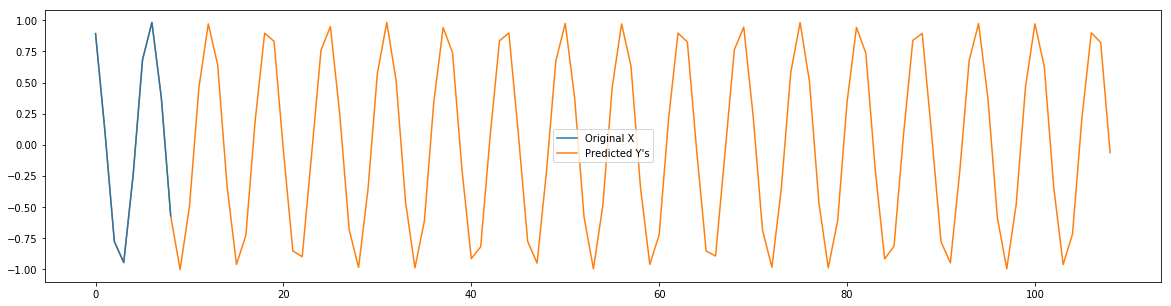

In [104]:
def plot_generated_sequence(x, x_index, model, max_sequence_len, do_ion=False):
    with torch.no_grad():
        if do_ion:
            display.clear_output(wait=True)
            plt.gca().cla()

        predicted_sequence = x[x_index]
        plt.plot(predicted_sequence.numpy().copy(), label='Original X', zorder=2)  # Lets plot that single x
        for i in range(max_sequence_len):
            next_value = model(predicted_sequence[-x.shape[1]:])
            predicted_sequence = torch.cat((predicted_sequence, model(predicted_sequence[-x.shape[1]:])))
        plt.plot(predicted_sequence.numpy().copy(), label='Predicted Y\'s', zorder=1)
        plt.legend()

        if not do_ion:
            plt.show()
        else:
            plt.pause(0.01)

plot_generated_sequence(x, i, trained_model, 100, do_ion=True)

WOW!! Our neural net is now knows how to act like a sine function! If you changed the sine function to a tanh, or cosine function, it could learn how to do those also!

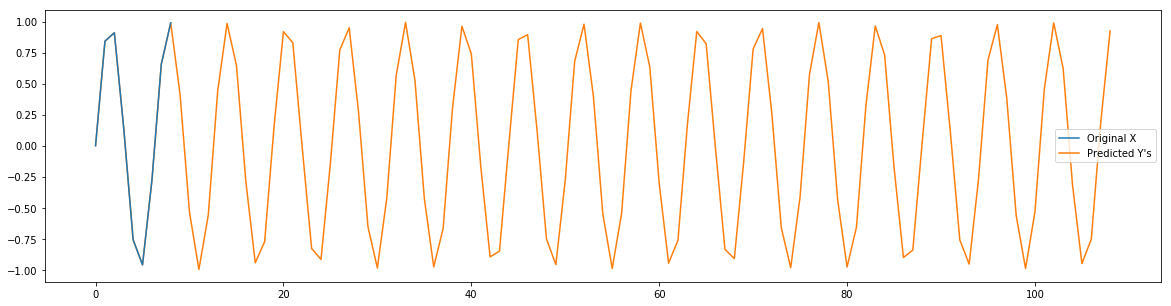

In [110]:
from functools import partial
fig = plt.figure()
mpl.rcParams['figure.figsize'] = (20,5)
from IPython import display
# We can also see if how fast the model learns this representation!
trained_model = train(x, y, epochs=30, model_progress_fn=partial(plot_generated_sequence, x=x, x_index=0, max_sequence_len=100, do_ion=True))

Ok, so lets try a fancier model. LSTMs! LSTM stands for Long Short Term Memory. This means that our neural net will now have some kind of memory similar to how you can me can remember sequences of events, numbers, images etc. The benefit here is that the sample is no longer a (N, 9) shape. Instead, we have a sample of (N, S, 1)! So lets look at the model.

In [158]:
def init_model():
    class LSTMModel(torch.nn.Module):
        def __init__(self, x_inputs, y_outputs, hidden_layer_size=1, n_layers=2):
            super(LSTMModel, self).__init__()
            self.lstm = torch.nn.LSTM(x_inputs.shape[1], 10, 2)
            self.linear_layer = torch.nn.Linear(10, y_outputs.shape[1])

        def forward(self, x_input):
            print(x_input)
            out, states = self.lstm(x_input)
            return self.linear_layer(out)
    
    return LSTMModel(x_inputs=x, y_outputs=y)

model = init_model()
some_x = x[0].unsqueeze(0).unsqueeze(0)
print(some_x)
print(model(some_x))

tensor([[[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,
           0.6570,  0.9894]]])
tensor([[[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,
           0.6570,  0.9894]]])
tensor([[[-0.1403]]], grad_fn=<AddBackward0>)
